<a href="https://colab.research.google.com/github/aszxcnm22/eee/blob/main/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#การ Segmentation (หรือ Image Segmentation) คือกระบวนการแบ่งภาพออกเป็นส่วน ๆ หรือกลุ่มของพิกเซลที่มีความหมายเดียวกัน เช่น ส่วนของวัตถุหรือพื้นหลัง ซึ่งถูกใช้อย่างแพร่หลายในหลายสาขา เช่น การแพทย์, การขับรถอัตโนมัติ,การตรวจสอบวัตถุในภาพ และอื่น ๆ




### ประเภทของ Segmentation
###Semantic Segmentation
###แบ่งภาพออกเป็น class-level เช่น "ทั้งหมดที่เป็นแมว", "ทั้งหมดที่เป็นถนน"

###Instance Segmentation
###แยกวัตถุแต่ละ instance เช่น แมว 2 ตัวในภาพ ต้องแยกออกจากกัน

###Panoptic Segmentation
###รวม Semantic + Instance Segmentation

ตัวอย่างโมเดลยอดนิยมสำหรับ Segmentation
1. U-Net
ออกแบบมาสำหรับการแพทย์

Encoder-Decoder structure พร้อม skip connections

เหมาะกับงานที่มีข้อมูลไม่เยอะ

2. SegNet
คล้าย U-Net แต่ใช้ max-pooling indices ในการ upsample

ประหยัด memory มากกว่า U-Net

3. DeepLab (v3, v3+)
ใช้ atrous convolution และ ASPP (Atrous Spatial Pyramid Pooling)

ให้ผลลัพธ์ดีมากใน segmentation แบบ fine-grained

DeepLabv3+ ใช้ Xception หรือ MobileNet เป็น backbone

4. Mask R-CNN
เป็น extension ของ Faster R-CNN

เพิ่ม branch สำหรับ segmentation mask

ใช้สำหรับ Instance Segmentation

5. PSPNet (Pyramid Scene Parsing Network)
ใช้ spatial pyramid pooling สำหรับ context awareness

ดีสำหรับ scene segmentation ที่ซับซ้อน

6. HRNet (High-Resolution Network)
รักษาความละเอียดสูงตลอดโครงข่าย

เหมาะกับงานที่ต้องการความละเอียดสูง เช่น landmark detection

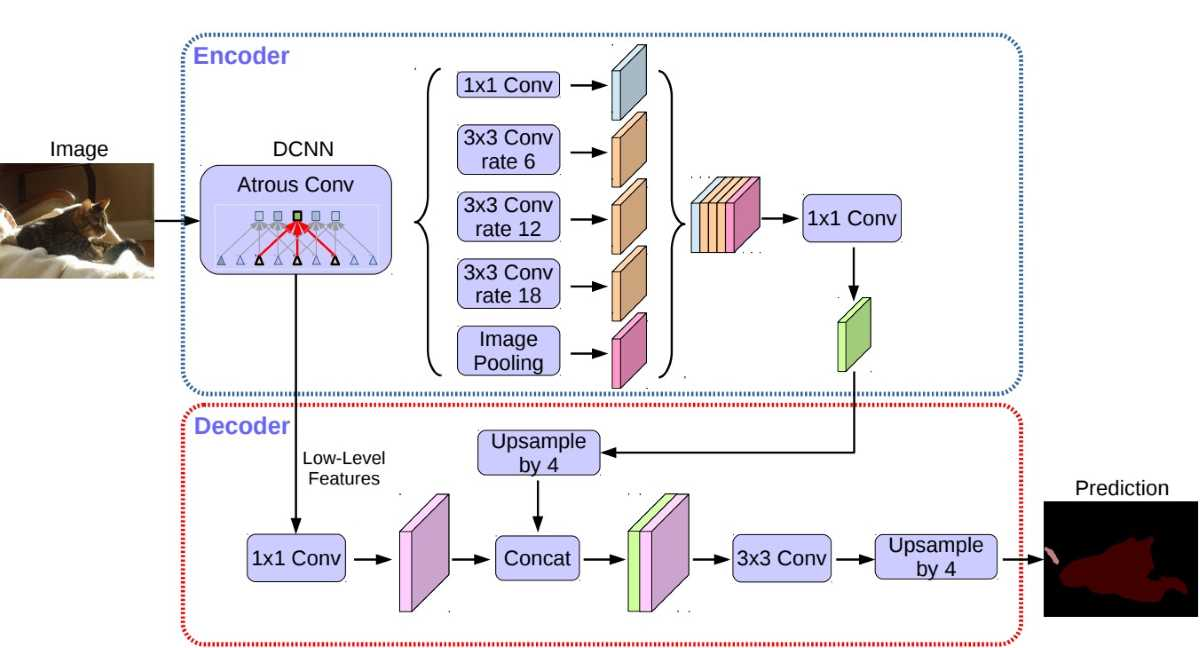

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:

!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 19.6 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


image_0_0_0 .png: Classes detected = [0 8]
image_0_0_0 .png: จำนวน pixel แมว = 63666, จำนวน pixel หมา = 0


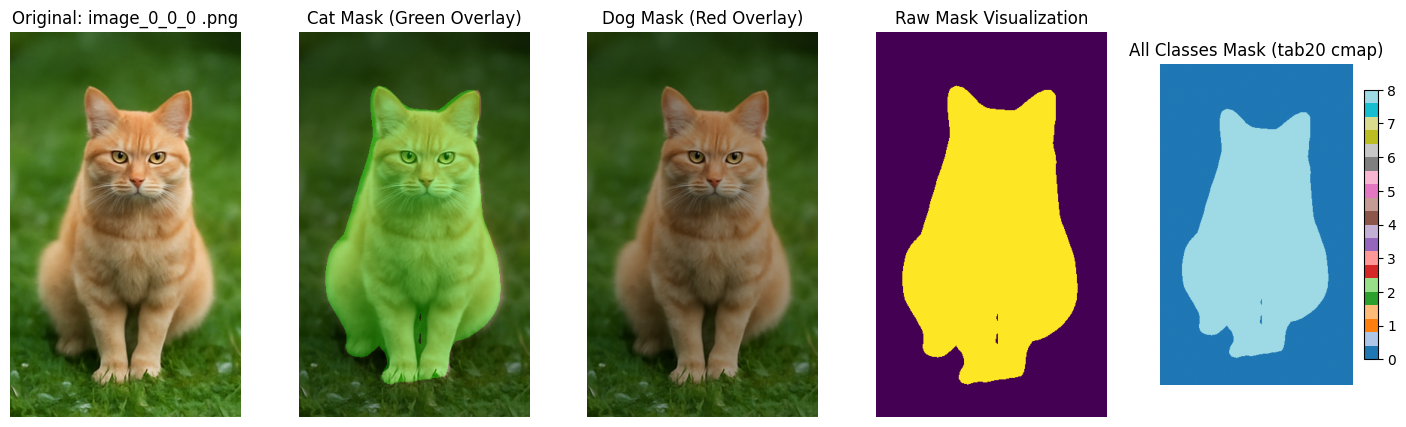

 image_0_2.png: Classes detected = [0 8]
 image_0_2.png: จำนวน pixel แมว = 61951, จำนวน pixel หมา = 0


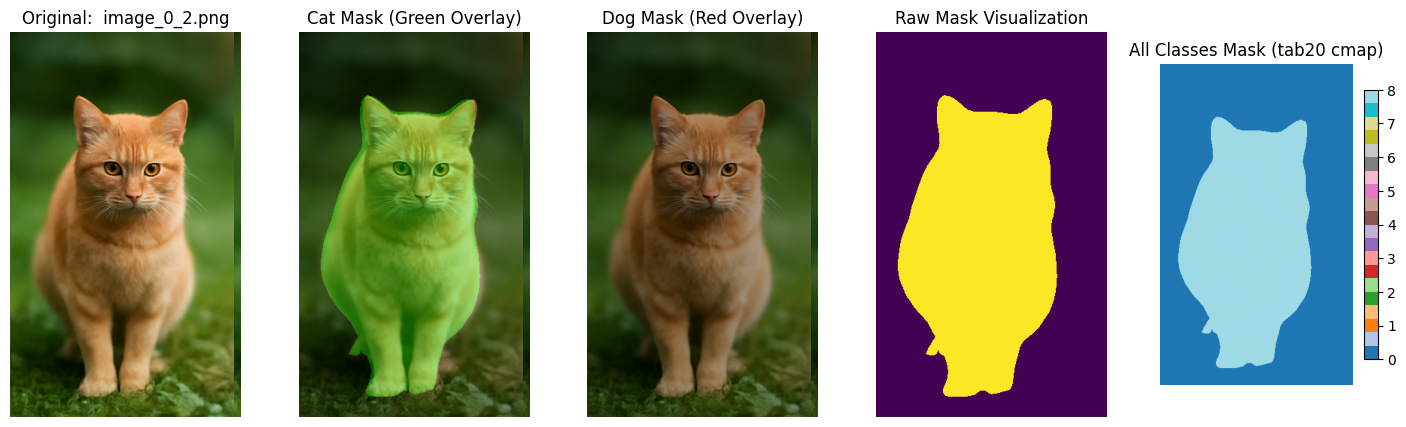

 image_0_3.png: Classes detected = [0 3 8]
 image_0_3.png: จำนวน pixel แมว = 52568, จำนวน pixel หมา = 0


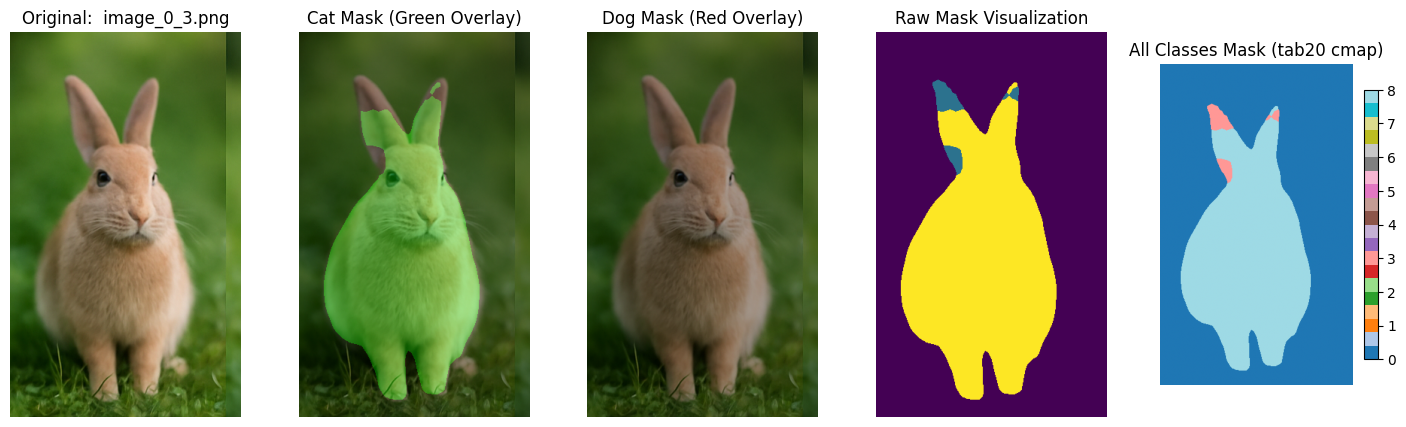

 image_0_4.png: Classes detected = [ 0 12]
 image_0_4.png: จำนวน pixel แมว = 0, จำนวน pixel หมา = 85982


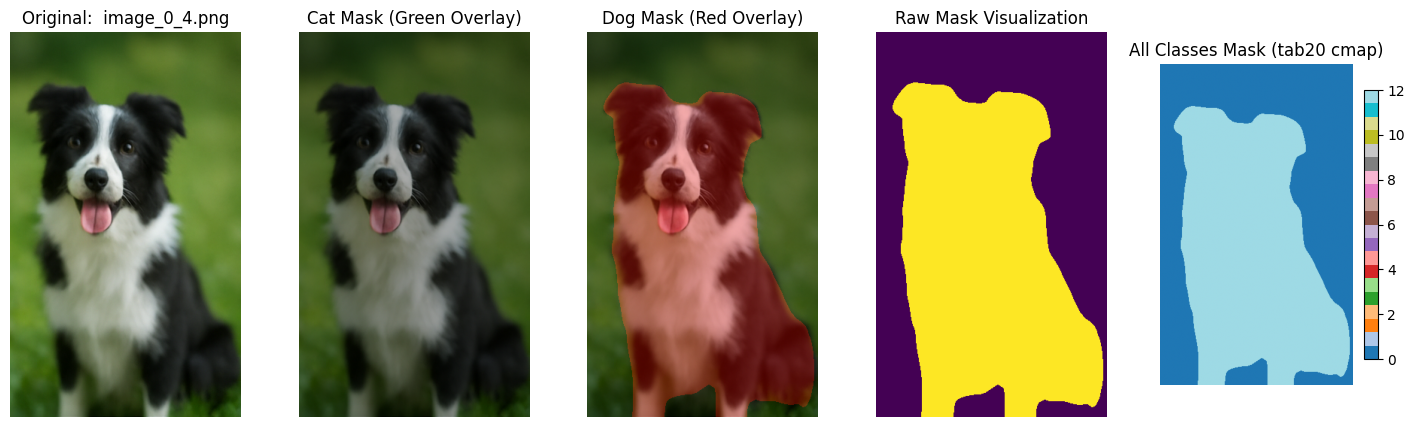

 image_0_1.png: Classes detected = [0 8]
 image_0_1.png: จำนวน pixel แมว = 46929, จำนวน pixel หมา = 0


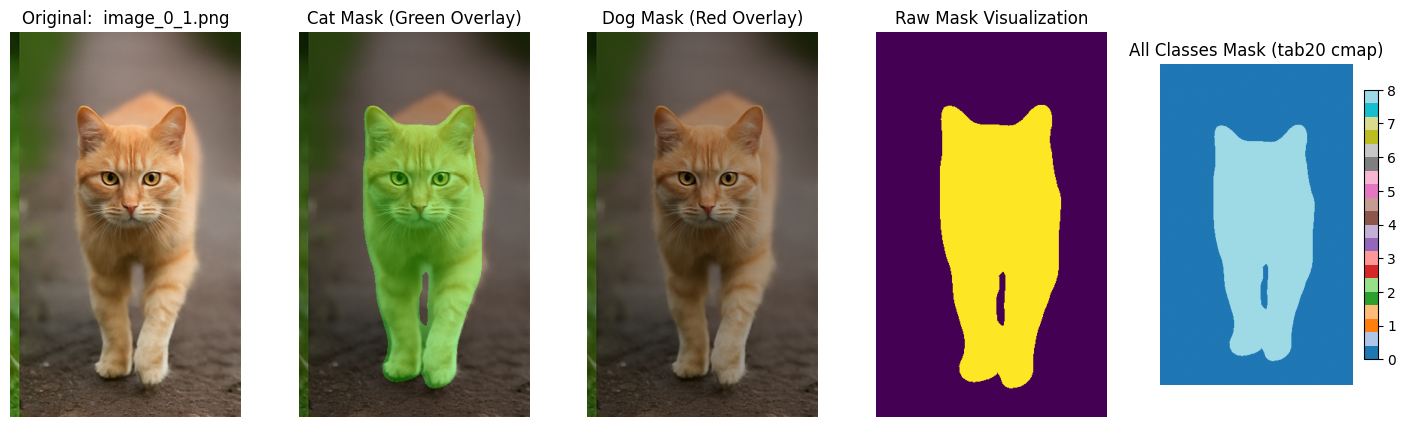

 image_0_0.png: Classes detected = [0 8]
 image_0_0.png: จำนวน pixel แมว = 63666, จำนวน pixel หมา = 0


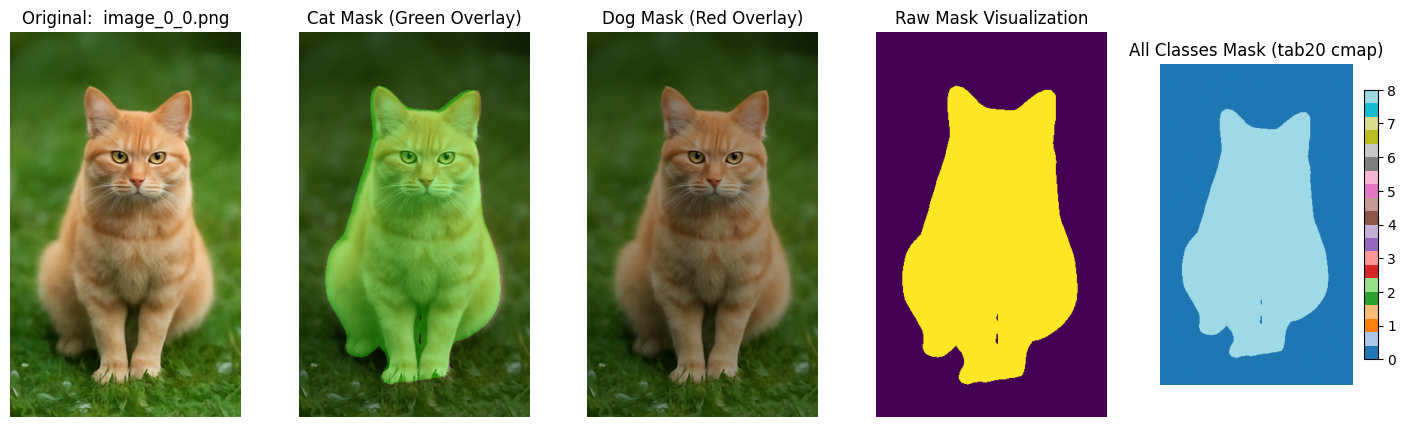

In [ ]:
import os
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# โหลดโมเดล DeepLabV3 pretrained (ResNet101 backbone)
model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

# Transform สำหรับภาพเข้าโมเดล
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# class ID ตาม COCO-Stuff สำหรับ DeepLabV3
CAT_CLASS_ID = 8
DOG_CLASS_ID = 12

def overlay_mask(image, mask, color):
    image_np = np.array(image).copy()
    colored_mask = np.zeros_like(image_np)
    colored_mask[mask] = color
    overlay = cv2.addWeighted(image_np, 0.7, colored_mask, 0.3, 0)
    return overlay

folder_path = "/content/drive/MyDrive/Data set  are test"
image_filenames = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

for img_name in image_filenames:
    img_path = os.path.join(folder_path, img_name)
    input_image = Image.open(img_path).convert("RGB")

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    with torch.no_grad():
        output = model(input_batch)['out'][0]

    output_predictions = output.argmax(0).byte().cpu().numpy()

    unique_classes = np.unique(output_predictions)
    print(f"{img_name}: Classes detected = {unique_classes}")

    cat_mask = (output_predictions == CAT_CLASS_ID)
    dog_mask = (output_predictions == DOG_CLASS_ID)

    print(f"{img_name}: จำนวน pixel แมว = {cat_mask.sum()}, จำนวน pixel หมา = {dog_mask.sum()}")

    cat_overlay = overlay_mask(input_image, cat_mask, [0, 255, 0])  # สีเขียว
    dog_overlay = overlay_mask(input_image, dog_mask, [255, 0, 0])  # สีแดง

    plt.figure(figsize=(18,5))

    plt.subplot(1,5,1)
    plt.title(f"Original: {img_name}")
    plt.imshow(input_image)
    plt.axis('off')

    plt.subplot(1,5,2)
    plt.title("Cat Mask (Green Overlay)")
    plt.imshow(cat_overlay)
    plt.axis('off')

    plt.subplot(1,5,3)
    plt.title("Dog Mask (Red Overlay)")
    plt.imshow(dog_overlay)
    plt.axis('off')

    plt.subplot(1,5,4)
    plt.title("Raw Mask Visualization")
    plt.imshow(output_predictions)
    plt.axis('off')

    plt.subplot(1,5,5)
    plt.title("All Classes Mask (tab20 cmap)")
    plt.imshow(output_predictions, cmap='tab20')
    plt.colorbar(shrink=0.7)
    plt.axis('off')

    plt.show()

# การครอบ (crop)

In [2]:
import os
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2

# โหลดโมเดล DeepLabV3 ที่ pretrained มาแล้วสำหรับ semantic segmentation
model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

# กำหนด preprocessing สำหรับภาพก่อนเข้าโมเดล
preprocess = transforms.Compose([
    transforms.ToTensor(),  # แปลงภาพเป็น tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize ด้วย mean และ std ตาม ImageNet
                         std=[0.229, 0.224, 0.225]),
])

# กำหนด class ID สำหรับแมวและหมาใน dataset COCO-Stuff
CAT_CLASS_ID = 8
DOG_CLASS_ID = 12

# โฟลเดอร์เก็บภาพต้นฉบับ
folder_path = "/content/drive/MyDrive/Data set  are test"
# โฟลเดอร์เก็บภาพที่ครอบแล้ว (crop)
output_folder = "/content/drive/MyDrive/Segmented_Output_Crop"
os.makedirs(output_folder, exist_ok=True)  # สร้างโฟลเดอร์ถ้ายังไม่มี

def crop_from_mask(image, mask):
    """
    ฟังก์ชันครอบภาพเฉพาะส่วนที่เป็น mask
    - image: PIL Image
    - mask: numpy boolean mask
    คืนค่า crop ของภาพส่วนที่ mask ครอบคลุม
    """
    coords = cv2.findNonZero(mask.astype(np.uint8))  # หาพิกัด pixel ที่ mask เป็น True
    if coords is None:
        return None  # ถ้าไม่มี pixel ที่ mask เป็น True ให้คืนค่า None
    x, y, w, h = cv2.boundingRect(coords)  # หา bounding box ของ pixel เหล่านั้น
    return image.crop((x, y, x + w, y + h))  # ครอบภาพตาม bounding box

# หาไฟล์ภาพที่นามสกุล .png, .jpg, .jpeg ในโฟลเดอร์
image_filenames = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

for img_name in image_filenames:
    img_path = os.path.join(folder_path, img_name)
    input_image = Image.open(img_path).convert("RGB")  # เปิดภาพและแปลงเป็น RGB
    input_tensor = preprocess(input_image)  # preprocessing
    input_batch = input_tensor.unsqueeze(0)  # เพิ่ม batch dimension

    with torch.no_grad():
        output = model(input_batch)['out'][0]  # ใช้โมเดลทำนาย segmentation
    output_predictions = output.argmax(0).byte().cpu().numpy()  # หา class ที่โมเดลทำนายสำหรับแต่ละ pixel

    # สร้าง mask สำหรับแมวและหมา
    cat_mask = (output_predictions == CAT_CLASS_ID)
    dog_mask = (output_predictions == DOG_CLASS_ID)

    base_name = os.path.splitext(img_name)[0]

    # ครอบภาพแมวและหมา ถ้ามี mask ที่ไม่ว่าง
    cat_crop = crop_from_mask(input_image, cat_mask)
    dog_crop = crop_from_mask(input_image, dog_mask)

    if cat_crop:
        cat_crop.save(os.path.join(output_folder, f"{base_name}_cat_crop.jpg"))
    if dog_crop:
        dog_crop.save(os.path.join(output_folder, f"{base_name}_dog_crop.jpg"))

print(" ครอบภาพ (crop) แมวและหมา เสร็จแล้ว ที่:", output_folder)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:02<00:00, 94.8MB/s]


 ครอบภาพ (crop) แมวและหมา เสร็จแล้ว ที่: /content/drive/MyDrive/Segmented_Output_Crop


# การลบพื้นหลังออกจากภาพ

In [3]:
import os
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np

# โหลดโมเดล DeepLabV3 pretrained
model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

# preprocessing ภาพเข้าโมเดล
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# class ID สำหรับแมวและหมา
CAT_CLASS_ID = 8
DOG_CLASS_ID = 12

folder_path = "/content/drive/MyDrive/Data set  are test"
output_folder = "/content/drive/MyDrive/Segmented_Output_BGRemoved"
os.makedirs(output_folder, exist_ok=True)

image_filenames = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

for img_name in image_filenames:
    img_path = os.path.join(folder_path, img_name)
    input_image = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    with torch.no_grad():
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

    # สร้าง mask สำหรับแมวและหมา
    cat_mask = (output_predictions == CAT_CLASS_ID)
    dog_mask = (output_predictions == DOG_CLASS_ID)
    combined_mask = cat_mask | dog_mask  # รวมกันทั้ง 2 mask

    input_np = np.array(input_image)
    # สร้างภาพใหม่แบบ RGBA สำหรับเก็บภาพพร้อม alpha channel
    rgba_img = np.zeros((input_np.shape[0], input_np.shape[1], 4), dtype=np.uint8)
    rgba_img[..., :3] = input_np  # ใส่ช่อง RGB
    rgba_img[..., 3] = (combined_mask * 255).astype(np.uint8)  # alpha channel: 255 ถ้า mask เป็น True, 0 ถ้าไม่ใช่

    base_name = os.path.splitext(img_name)[0]
    # บันทึกภาพ PNG ที่มี background โปร่งใส
    Image.fromarray(rgba_img).save(os.path.join(output_folder, f"{base_name}_bg_removed.png"))

print(" ลบพื้นหลังโปร่งใส เสร็จแล้ว ที่:", output_folder)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 ลบพื้นหลังโปร่งใส เสร็จแล้ว ที่: /content/drive/MyDrive/Segmented_Output_BGRemoved


# ลบพื้นหลังของภาพแมวและหมา โดยใช้โมเดล DeepLabV3 แล้วแทนที่พื้นหลังด้วย **สีดำ**

In [4]:
import os
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np

# ตรวจสอบว่าใช้ GPU ได้หรือไม่
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# โหลดโมเดล DeepLabV3 ไปที่ device และ set เป็นโหมดประเมินผล
model = models.segmentation.deeplabv3_resnet101(pretrained=True).to(device).eval()

# สร้าง transform สำหรับ resize + normalize ให้เข้ากับโมเดล
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),  # ลดขนาดภาพเพื่อเพิ่มความเร็ว
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# กำหนด class ID ของแมวและหมา จาก COCO dataset
CAT_CLASS_ID = 8
DOG_CLASS_ID = 12

#  กำหนดโฟลเดอร์ต้นทางที่ต้องการอ่าน (รวม subfolder ทั้งหมด)
folder_path = "/content/drive/MyDrive/dataset/training_set/cats"

#  กำหนดโฟลเดอร์ปลายทางที่จะเซฟภาพผลลัพธ์
output_folder = "/content/drive/MyDrive/Segmented_Output_BGBlack"
os.makedirs(output_folder, exist_ok=True)

#  ฟังก์ชันสำหรับดึง path ของทุกภาพจาก folder และ subfolder
def get_all_image_paths(root_folder, extensions=('.jpg', '.jpeg', '.png')):
    image_paths = []
    for dirpath, _, filenames in os.walk(root_folder):
        for filename in filenames:
            if filename.lower().endswith(extensions):
                image_paths.append(os.path.join(dirpath, filename))
    return image_paths

#  อ่านภาพทั้งหมดจากโฟลเดอร์และโฟลเดอร์ย่อย
image_paths = get_all_image_paths(folder_path)

#  ประมวลผลภาพทีละภาพ
for img_path in image_paths:
    img_name = os.path.basename(img_path)  # แค่ชื่อไฟล์ เช่น "cat1.jpg"
    input_image = Image.open(img_path).convert("RGB")

    # ทำ preprocessing และส่งไปที่ GPU (ถ้ามี)
    input_tensor = preprocess(input_image).to(device)
    input_batch = input_tensor.unsqueeze(0)

    # ส่งเข้าโมเดลเพื่อ segment
    with torch.no_grad():
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

    # สร้าง mask สำหรับแมวและหมา
    cat_mask = (output_predictions == CAT_CLASS_ID)
    dog_mask = (output_predictions == DOG_CLASS_ID)
    combined_mask = cat_mask | dog_mask

    # ทำภาพ background เป็นดำ โดยคัดเฉพาะ pixel ที่ตรง mask
    input_np = np.array(input_image.resize((512, 512)))
    bg_black = np.zeros_like(input_np)
    for c in range(3):
        bg_black[..., c] = np.where(combined_mask, input_np[..., c], 0)

    # บันทึกภาพที่ตัดพื้นหลังออกแล้วเป็นไฟล์ใหม่
    base_name = os.path.splitext(img_name)[0]
    save_path = os.path.join(output_folder, f"{base_name}_bg_black.jpg")
    Image.fromarray(bg_black).save(save_path)

print(f" ประมวลผลรูปทั้งหมด {len(image_paths)} รูปเสร็จสิ้น บันทึกไว้ที่: {output_folder}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

In [14]:
import os

# กำหนดโฟลเดอร์ที่ต้องการตรวจสอบ
folder_path = "/content/drive/MyDrive/DataSegmentation_set"

# นับจำนวนไฟล์ภาพ (รองรับ .jpg, .jpeg, .png)
image_extensions = ('.jpg', '.jpeg', '.png')
image_filenames = [f for f in os.listdir(folder_path) if f.lower().endswith(image_extensions)]
image_count = len(image_filenames)

# แสดงผล
print(f" พบรูปภาพทั้งหมด: {image_count} รูป")



โหลดภาพได้ทั้งหมด: 10 จาก 10 ไฟล์


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from tqdm import tqdm
from PIL import Image
import torch.nn.functional as F
from torchvision import models
from pathlib import Path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
vgg19 = models.vgg19(pretrained=True).to(device)
vgg19.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [9]:

# โหลดโมเดล VGG19 ที่เทรนมากับ ImageNet แล้ว และนำไปไว้บนอุปกรณ์ (GPU หรือ CPU)
vgg19 = models.vgg19(pretrained=True).to(device)
vgg19.eval()

# กำหนดการแปลงภาพก่อนนำเข้าโมเดล
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# โหลดชุดข้อมูลจากโฟลเดอร์ โดยใช้โครงสร้าง ImageFolder (แยกตาม class)
dataset = datasets.ImageFolder(root="/content/drive/MyDrive/DataSegmentation_set/test_set", transform=transform)

# สร้าง DataLoader สำหรับโหลดภาพทีละ 1 (batch_size=1)
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

# เตรียม list สำหรับเก็บ feature, label, และชื่อภาพ
features_list = []
labels_list = []
image_names_list = []

# วนลูปดึง feature ทีละภาพจาก DataLoader
for i, (img, label) in tqdm(enumerate(data_loader), total=len(data_loader)):
    img = img.to(device)  # ส่งภาพไปยังอุปกรณ์ที่ใช้ (GPU/CPU)

    with torch.no_grad():
        features = vgg19.features(img)
        features = features.view(features.size(0), -1).cpu().numpy().flatten()

    label_name = dataset.classes[label.item()]  # ดึงชื่อคลาส เช่น 'cat' หรือ 'dog'
    image_name = Path(dataset.imgs[i][0]).name  # ดึงชื่อไฟล์ภาพ เช่น 'cat1.jpg'

    features_list.append(features)
    labels_list.append(label_name)
    image_names_list.append(image_name)

# รวมข้อมูลทั้งหมดเป็น DataFrame โดยใช้ pandas
features_df = pd.DataFrame(features_list)
features_df['Label'] = labels_list
features_df['Image_Name'] = image_names_list

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


In [12]:
print(features_df.head())

     0    1    2    3    4    5    6    7    8    9  ...  25079  25080  25081  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   

   25082  25083  25084  25085  25086  25087     Label  
0    0.0    0.0    0.0    0.0    0.0    0.0  Cat_test  
1    0.0    0.0    0.0    0.0    0.0    0.0  Cat_test  
2    0.0    0.0    0.0    0.0    0.0    0.0  Cat_test  
3    0.0    0.0    0.0    0.0    0.0    0.0  Cat_test  
4    0.0    0.0    0.0    0.0    0.0    0.0  Cat_test  

[5 rows x 25089 columns]


In [11]:
features_df = features_df.drop(columns=['Image_Name'])

In [14]:
features_df.to_csv('/content/drive/MyDrive/DataSegmentation_set/WWW.csv',index=False)

In [27]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 594.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.2 MB/s eta 0:00:00


In [16]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import tensorflow as tf
# this get the images we want
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D

In [17]:
# สร้างออบเจกต์ ImageDataGenerator สำหรับฝึก (training) โดยเพิ่มการปรับแต่งภาพ (augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,        # ปรับค่าสีภาพให้อยู่ในช่วง 0-1 แทน 0-255
    shear_range=0.2,       # สุ่มหักมุมภาพ (shear) เพื่อเพิ่มความหลากหลายภาพ
    zoom_range=0.2,        # สุ่มซูมภาพบางส่วน
    horizontal_flip=True   # สุ่มกลับภาพซ้าย-ขวา (mirror)
)

In [18]:
# โหลดชุดข้อมูลฝึกจากโฟลเดอร์, ขนาดภาพ resize เป็น 64x64, batch ละ 32 ภาพ,
# และใช้ class_mode = 'binary' เพราะเป็นงานจำแนก 2 คลาส (binary classification)
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/DataSegmentation_set/training_set',
    target_size=(64,64),
    batch_size=32,
    class_mode='binary'
)


Found 100 images belonging to 2 classes.


In [19]:
# สร้าง ImageDataGenerator สำหรับชุดทดสอบ (validation/test)
# โดยปรับค่าสีภาพให้อยู่ในช่วง 0-1 เท่านั้น (ไม่มี augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# โหลดชุดข้อมูลทดสอบจากโฟลเดอร์ ด้วยการตั้งค่าคล้ายกับชุดฝึก
test_set = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/DataSegmentation_set/test_set',
    target_size=(64,64),
    batch_size=32,
    class_mode='binary'
)

Found 20 images belonging to 2 classes.


In [20]:
# เริ่มสร้างโมเดล CNN แบบ Sequential (เรียงชั้นตามลำดับ)
cnn = tf.keras.models.Sequential()

# ขั้นตอนที่ 1: เพิ่มชั้น convolutional layer
# filters=32 หมายถึงสร้างฟิลเตอร์ 32 ตัว
# kernel_size=3 คือขนาดฟิลเตอร์ 3x3
# padding='same' คือเพิ่ม padding รอบภาพเพื่อให้ output มีขนาดเท่าภาพเข้า
# activation='relu' คือใช้ฟังก์ชัน activation แบบ ReLU
# input_shape = [64,64,3] คือขนาดภาพ 64x64 พิกเซล มี 3 ช่องสี RGB
cnn.add(tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', input_shape=[64,64,3]))

# ขั้นตอนที่ 2: เพิ่ม MaxPooling layer ลดขนาดภาพลงครึ่งหนึ่ง (2x2 pooling)
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# เพิ่ม convolutional layer อีกชั้น (คล้ายขั้นตอน 1 แต่ไม่มีกำหนด input_shape เพราะรับจากชั้นก่อนหน้า)
cnn.add(tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# ขั้นตอนที่ 3: Flattening แปลง feature map 2D เป็น vector 1D เพื่อนำเข้าสู่ชั้น Fully Connected
cnn.add(tf.keras.layers.Flatten())


# ขั้นตอนที่ 4: Fully Connected layer (Dense)
# units=128 คือจำนวนหน่วยในชั้นนี้
# activation='relu' ใช้ ReLU
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# ขั้นตอนที่ 5: Output layer
# units=1 เพราะ binary classification
# activation='sigmoid' ให้ค่า output อยู่ในช่วง 0-1 (probability ของคลาส 1)
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# แสดงสรุปโครงสร้างโมเดล
cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,058,977 (4.04 MB)

 Trainable params: 1,058,977 (4.04 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# คอมไพล์โมเดล
# optimizer='adam' ใช้อัลกอริทึม Adam ปรับน้ำหนักโมเดล
# loss='binary_crossentropy' เพราะเป็น classification 2 คลาส
# metrics=['accuracy'] ให้วัดความแม่นยำเป็นตัวชี้วัด
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ฝึกโมเดล (train) กับข้อมูลที่เตรียมไว้
# x=training_set ใช้ชุดฝึก
# validation_data=test_set ใช้ชุดทดสอบสำหรับวัด validation loss/accuracy
# epochs=10 จำนวนรอบการฝึก 10 รอบ
cnn.fit(x=training_set, validation_data=test_set, epochs=5)

Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5000 - loss: 0.8559

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 9s/step - accuracy: 0.5000 - loss: 0.8490 - val_accuracy: 0.4500 - val_loss: 0.6952
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 886ms/step - accuracy: 0.4210 - loss: 0.7399 - val_accuracy: 0.5500 - val_loss: 0.6813
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step - accuracy: 0.5344 - loss: 0.6916 - val_accuracy: 0.5500 - val_loss: 0.6839
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 363ms/step - accuracy: 0.5975 - loss: 0.6856 - val_accuracy: 0.4500 - val_loss: 0.6914
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - accuracy: 0.4877 - loss: 0.6937 - val_accuracy: 0.7500 - val_loss: 0.6681


In [24]:
import numpy as np
from tensorflow.keras.preprocessing import image

# โหลดภาพที่จะทดสอบ ขนาด 64x64 (resize อัตโนมัติ)
test_image = image.load_img('/content/drive/MyDrive/DataSegmentation_set/test_set/Dog_test/สำเนาของ dog.4681_bg_black.jpg', target_size=(64,64))

# แปลงภาพเป็นอาเรย์ (numpy array)
test_image = image.img_to_array(test_image)

# ปรับค่าสีให้อยู่ในช่วง 0-1 เช่นเดียวกับตอน train
test_image = test_image / 255

# ขยายมิติข้อมูลจาก (64,64,3) เป็น (1,64,64,3)
test_image = np.expand_dims(test_image, axis=0)

# ทำนายผลภาพด้วยโมเดล CNN
result = cnn.predict(test_image)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [25]:
result

array([[0.49615607]], dtype=float32)

In [29]:
if result[0] <= 0.5:
    print('the image is a cat')
else:
    print('the image is a dog')

the image is a cat
